# Получение гармонической структуры композиции

In [23]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

`librosa.load` загружает композицию в виде временного ряда с заданной частотой дискретизации `sr`

Для понимания процесса:

Аналоговый сигнал - непрерывен во времени, определен во все моменты; колебания напряжения, возникающие из-за колебаний мембраны в микрофоне

Чтобы превратить аналоговый сигнал в цифровой, проводится процесс дискретизации. Частота дискретизации sr - с какими интервалами по времени идут данные об уровне сигнала; глубина дискретизации - разрядность числа, которым описывается уровень сигнала

Pitch classes - набор из 12 высотных классов, соответствующих высотам нот без учета октавы (сдвиг на октаву значит умножение в 2 раза)

In [24]:
# PITCH_CLASSES = ['a', 'a#', 'b', 'c', 'c#', 'd', 'd#', 'e', 'f', 'f#', 'g', 'g#']
PITCH_CLASSES = ['c', 'c#', 'd', 'd#', 'e', 'f', 'f#', 'g', 'g#', 'a', 'a#', 'b']
HARMONICS_COEF = 0.5
NC_SENSITIVITY_COEF = 0.6
CHORDS_4_SENSITIVITY_COEF = 0.7

Гармоники: при звучании ноты одновременно с ней звучат ее гармоники - ноты с кратными фундаментальной ноте частотами, но меньшей интенсивности. Первые гармоники можно найти прибавлением интервалов: h1 = n + октава, h2 = h1 + чистая квинта, h3 = h2 + чистая кварта, h4 = h3 + большая терция, h5 = h4 + малая терция и т.д.

Гармоники нужны для уточнения темплейтов аккордов. к примеру аккорд CEG (C_maj) можно в идеальном виде записать как [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]. Однако на деле звучать также будут ноты, отмеченные гармониками: [1, 0, 0.6, 0, 1, ...]

In [25]:
SEVENTH = {"_dom7": (4, 7, 10), "_min7": (3, 7, 10), "_maj7": (4, 7, 11), "_half_dim7": (3, 6, 10), "_dim7": (3, 6, 9)}

def get_harmonics(mask):
    harmonics = [[1] if el == 1 else [] for el in mask]
    for i in range(len(harmonics)):
        if 1 in harmonics[i]:
            perfect_fifth = (i + 7) % 12
            perfect_fourth = (perfect_fifth + 5) % 12
            major_third = (perfect_fourth + 4) % 12
            
            harmonics[perfect_fifth].append(2)
            harmonics[perfect_fourth].append(3)
            harmonics[major_third].append(4)
    return harmonics

def get_weights(harmonic_array):
    np_harmonic_ar_m1 = np.array(harmonic_array) - 1
    return np.sum(HARMONICS_COEF ** np_harmonic_ar_m1)

def get_perfect_fifth_mask(index, isMajor):
    if index >= 12:
        print('error')
        return
    
    if isMajor:
        diff = 4
    else:
        diff = 3
        
    fifth = 7
    
    mask = [0 for i in range(12)]
    mask[index] = 1
    
    mask[(index + fifth) % 12] = 1
    mask[(index + diff) % 12] = 1
    return mask, PITCH_CLASSES[index] + ("_maj" if isMajor else "_min")
    

def get_seventh_mask(index):
    if index >= 12:
        print('error')
        return
    
    masks = {}
    for key, val in SEVENTH.items():
        mask = [0 for i in range(12)]
        
        mask[index] = 1
        
        for diff in val:
            mask[(index + diff) % 12] = 1
        
        masks[PITCH_CLASSES[index] + key] = mask
    return masks

def get_mask_with_harmonics(mask):
    harmonics = get_harmonics(mask)
    pc_weights = np.array([get_weights(harmonic) for harmonic in harmonics])
    
    return normalize([pc_weights])[0]

In [26]:
CHORDS_REVERTED = {} # mapping mask to chord name
BASE_MASKS = {} # chord name to raw mask (without harmonics)
for index in range(12):
    min_triad, name_1 = get_perfect_fifth_mask(index, True)
    maj_triad, name_2 = get_perfect_fifth_mask(index, False)
    
    BASE_MASKS[name_1] = min_triad
    BASE_MASKS[name_2] = maj_triad
    
    min_triad_h = get_mask_with_harmonics(min_triad)
    maj_triad_h = get_mask_with_harmonics(maj_triad)
    
    CHORDS_REVERTED[tuple(min_triad_h.tolist())] = name_1
    CHORDS_REVERTED[tuple(maj_triad_h.tolist())] = name_2
    
    sevenths = get_seventh_mask(index)
    CHORDS_REVERTED.update({tuple(get_mask_with_harmonics(val).tolist()) : key for key, val in sevenths.items()})
    BASE_MASKS.update(sevenths)

In [27]:
{val: key for key, val in CHORDS_REVERTED.items()}["c_maj"]

(0.46676002800933664,
 0.0,
 0.18670401120373464,
 0.0,
 0.5134360308102702,
 0.0,
 0.0,
 0.6534640392130713,
 0.04667600280093366,
 0.0,
 0.0,
 0.23338001400466832)

In [28]:
def print_chord(mask):
    return CHORDS_REVERTED[mask]

In [29]:
def sort_index(lst, rev=True):
    index = range(len(lst))
    s = sorted(index, reverse=rev, key=lambda i: lst[i])
    return s

def n_max_els(lst, n):
    if (n <= len(lst)):
        return sort_index(lst)[:n]
    return lst


In [30]:
def plt_chord_masks(cols):
    chords = list(CHORDS_REVERTED.keys())
    rows = len(chords) // cols
    fig, axs = plt.subplots(rows, cols)
    fig.set_figheight(60)
    fig.set_figwidth(30)

    index = 0
    for row in range(rows):
        for col in range(cols):
            if index >= len(chords) - 1:
                break
            axs[row, col].bar(PITCH_CLASSES, chords[index])
            axs[row, col].set_title(print_chord(chords[index]))
            index += 1

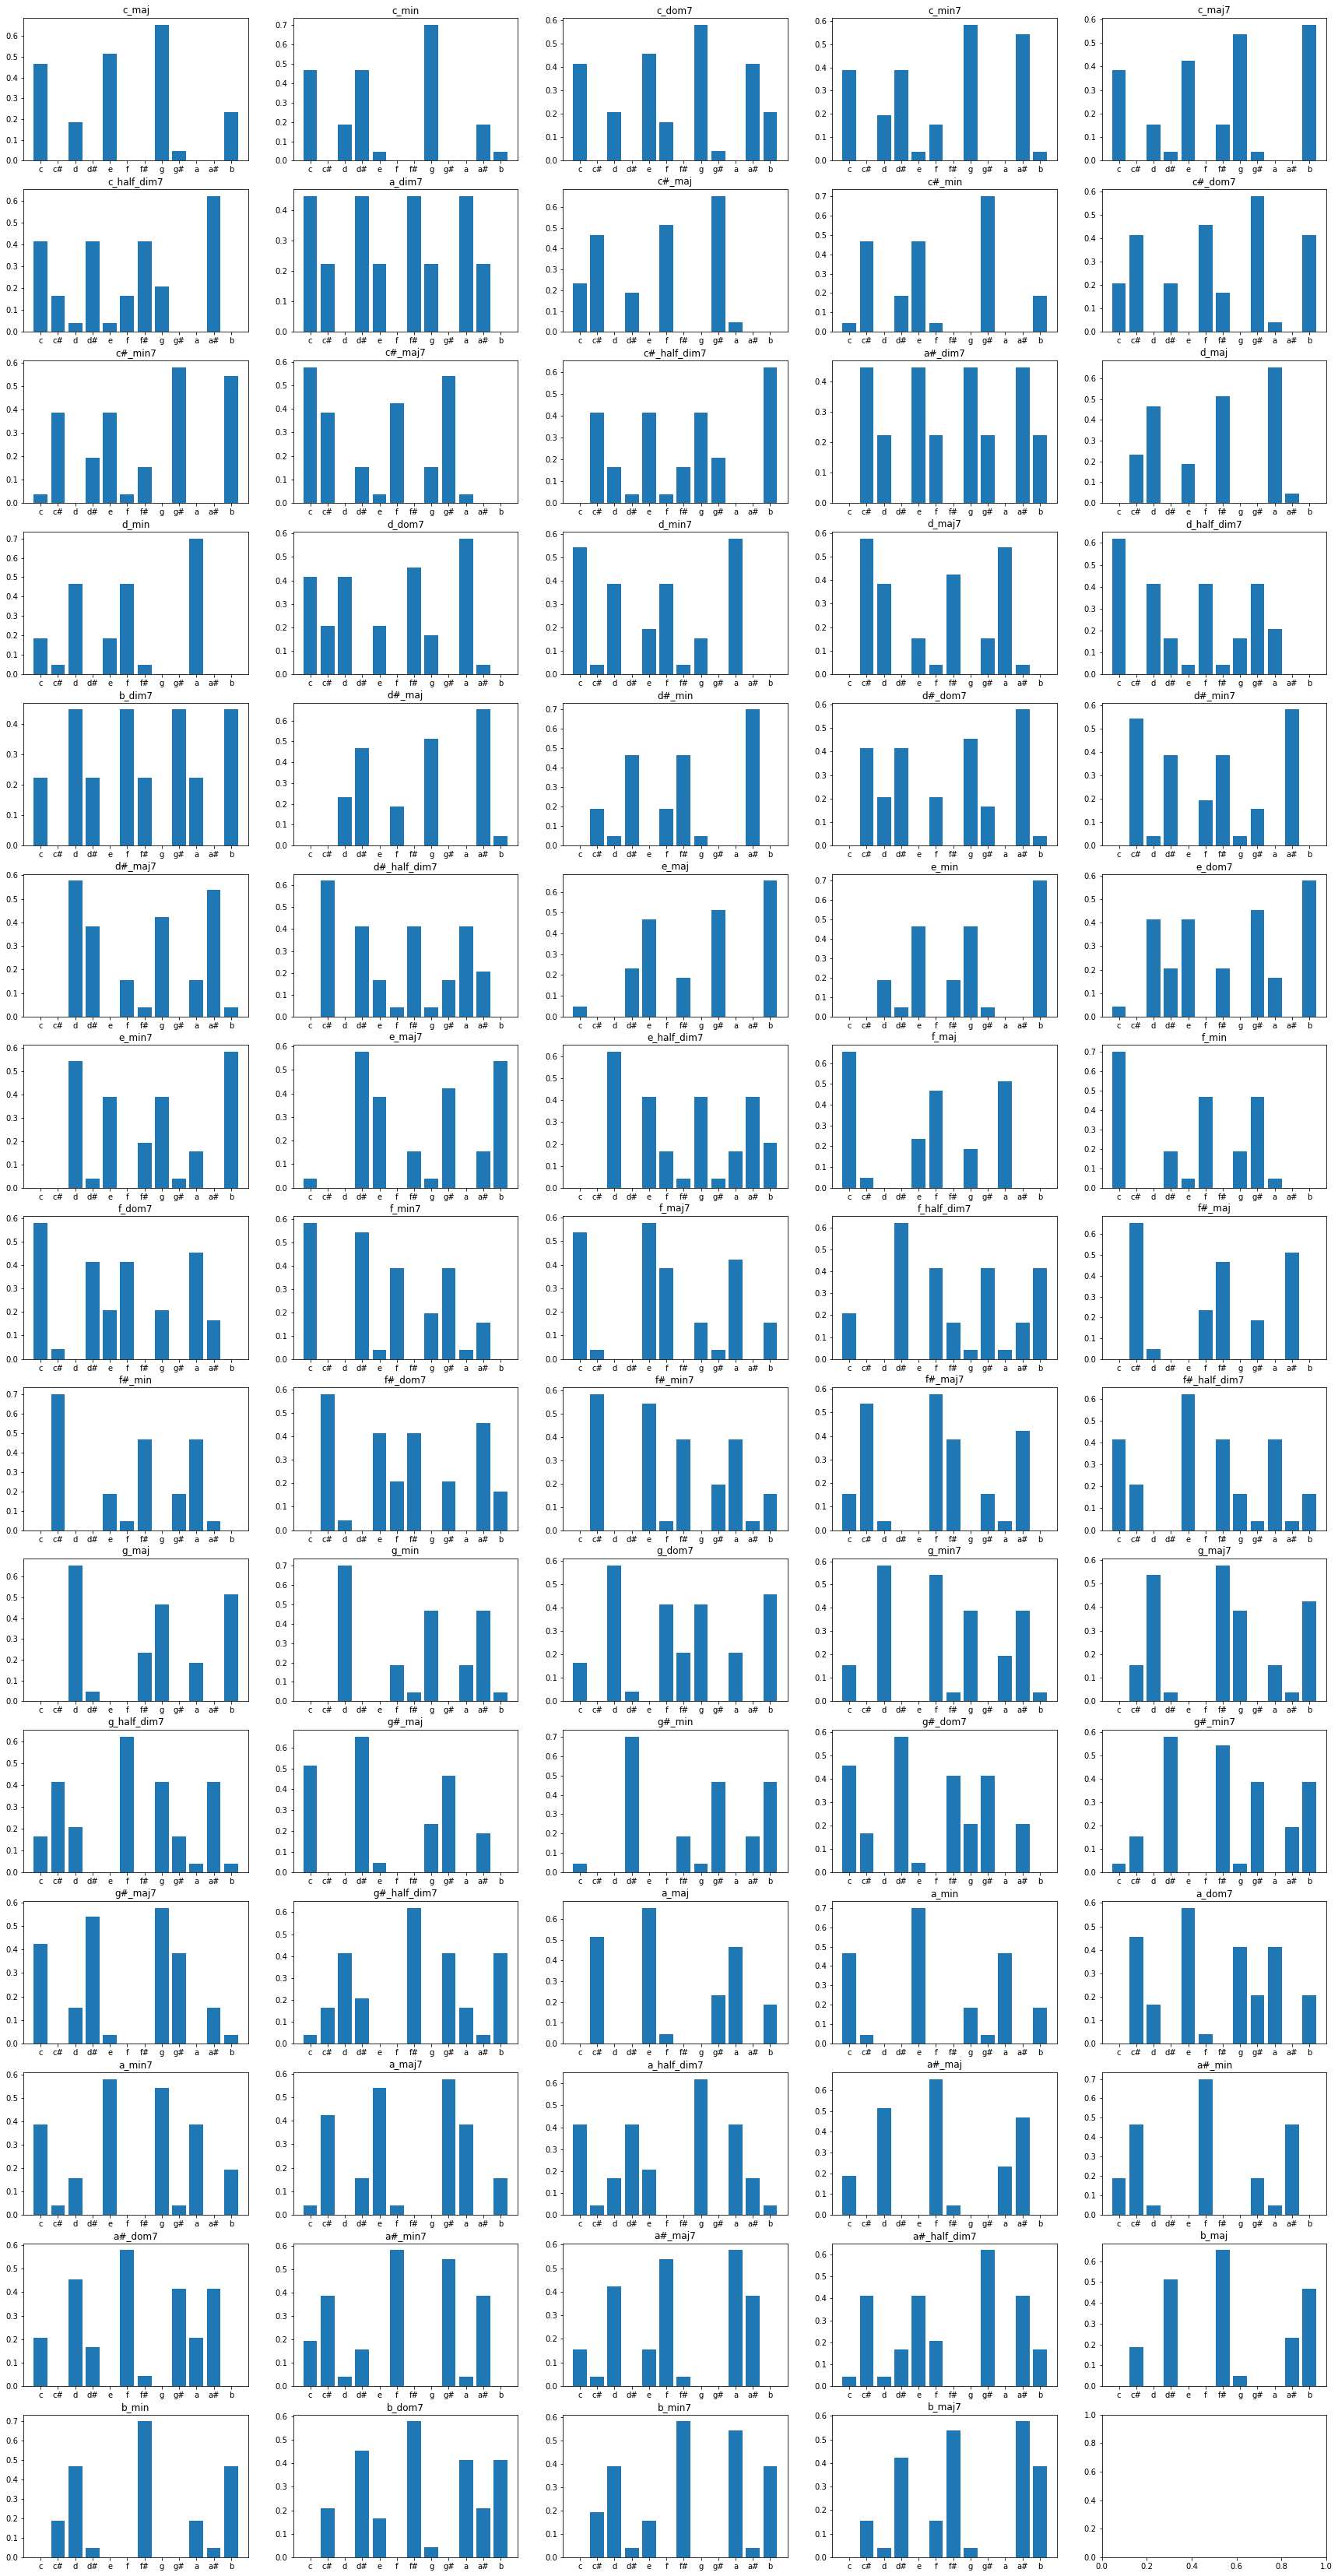

In [31]:
plt_chord_masks(5)

In [32]:
def cosine_sim(mask, vector):
    dot_product = np.dot(mask, vector) # x.y
    norm_mask = np.linalg.norm(mask) #|x|
    norm_vector = np.linalg.norm(vector) #|y|
    return dot_product / (norm_mask * norm_vector)

При процессинге композиции сначала она загружается с помощью librosa в формате временного ряда. Затем для композиции находятся точки, на которые выпадают "биения" или beats - по-простому это точки, в которых слушатель мог бы "притопывать ногой"; доказано, что именно в точках beats вероятнее всего смена аккорда. Далее для композиции находятся "вектора цветности", или PCP. Уже эти вектора сравниваются с подсчитанными масками и таким образом находится ближайший к звучащему аккорд.

In [33]:
def process_composition_librosa(path):
    y, sr = librosa.load(path, sr=44000)
    print("Composition duration is ", librosa.get_duration(y=y, sr=sr))
    tempo, beats = librosa.beat.beat_track(y=y, sr=sr)
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    return beats, chroma_stft

def get_chords_per_frame(chroma_stft):
    chords_masks = list(CHORDS_REVERTED.keys())
    chords = []
    for vector in chroma_stft.T:
        max_sim = 0
        probable_mask = print_chord(chords_masks[0])
        for mask in chords_masks:
            sim = cosine_sim(mask, vector)
            if np.all(mask == 1):
                sim *= NC_SENSITIVITY_COEF # sensitivity tuning
            if "7" in print_chord(mask):
                sim *= CHORDS_4_SENSITIVITY_COEF
            if sim > max_sim:
                max_sim = sim
                probable_mask = print_chord(mask)
        chords.append(probable_mask)
    return chords

def get_actual_chords(chords, beats):
    chords_to_merge = np.split(chords, beats)
    actual_chords = []
    for chords in chords_to_merge:
        chords.sort()

        max_count = 1 
        res = chords[0]
        curr_count = 1

        for i in range(1, len(chords)):
            if (chords[i] == chords[i - 1]):
                curr_count += 1

            else :
                if (curr_count > max_count):
                    max_count = curr_count
                    res = chords[i - 1]
                curr_count = 1

        if (curr_count > max_count):
            max_count = curr_count
            res = chords[len(chords) - 1]
        actual_chords.append(res)
    return list(filter(lambda x: x != '-', actual_chords))
    
def process_composition(path):
    beats, chroma_stft = process_composition_librosa(path)
    unmerged = get_chords_per_frame(chroma_stft)
    return get_actual_chords(unmerged, beats)
    


In [34]:
path = "/Users/stacy-zlato/Documents/вкр/tlsp-eycte.wav"
beats, chroma_stft = process_composition_librosa(path)

Composition duration is  193.86554545454544


In [35]:
chords = process_composition(path)

Composition duration is  193.86554545454544


/var/folders/wk/nl98v9pj0nl3jn3qgc8yzg8sk_pd53/T/ipykernel_56533/3600865441.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return dot_product / (norm_mask * norm_vector)


# SIMPLICIAL COMPLEX

In [36]:
from simplicial import *
from collections import Counter
import itertools

In [37]:
chords_cnt = dict(Counter(chords))

In [38]:
all_chords = np.sum(list(chords_cnt.values()))

chords_freq = {key: val / all_chords for key, val in chords_cnt.items()} # chord : freq

In [39]:
masks = {tuple(BASE_MASKS[key]) : val for key, val in chords_freq.items()} # mask : freq
chords_dict = {tuple(BASE_MASKS[key]) : key for key in chords_cnt.keys()} # mask : chord

Для полученных аккордов строится фильтрованный симплициальный комплекс. Фильтрация происходит в зависимости от частотности аккорда в композиции: в первый комплекс фильтрации попадают только самые частотные аккорды, далее с шагом фильтрации в 0.005 рассматриваются все менее и менее частотные, пока не получим комплекс, содержащий в себе все аккорды.

In [40]:
def getCombinations(lst):
    combs = []
    for r in range(1, len(lst) + 1):
        combs.extend(itertools.combinations(lst, r))
    return combs

In [41]:
chords_filtration = Filtration()

step = 0.005
max_filtration = np.max(list(chords_freq.values()))

In [42]:
already_in_filtration = set()
freq = max_filtration
index = 0.0
while len(already_in_filtration) != len(chords_dict.keys()) and freq >= 0:
    chords_filtration.setIndex(index)
    
    appropriate = set(filter(lambda x: chords_freq[x] >= freq, list(chords_freq.keys())))
    to_add = appropriate - already_in_filtration
    already_in_filtration.update(to_add)
    
    for chord in to_add:
        mask = BASE_MASKS[chord]
        notes = np.where(np.array(mask) == 1)[0]
        ids = [PITCH_CLASSES[note] for note in notes]
        simplices = getCombinations(ids)
        
        for simplex in simplices:
            id = "".join(simplex)
            if not chords_filtration.containsSimplex(id):
                chords_filtration.addSimplexWithBasis(id=id, bs=simplex)
                
    freq -= step
    index += 1.0

In [43]:
chords_filtration.bettiNumbers()

{0: 1, 1: 4, 2: 0}

In [44]:
i = 0
for c in chords_filtration.complexes():
    if (i == 3 or i == 1):
        print(c.boundaryOperator(k=1))
        print(c.simplices())
        print(c.boundary(['ca']))
    i += 1

[[1 1 0]
 [1 0 1]
 [0 1 1]]
['c', 'e', 'a', 'ce', 'ca', 'ea', 'cea']
{'a', 'c'}
[[1 1 0 0 0 0]
 [1 0 1 0 0 0]
 [0 1 1 0 1 1]
 [0 0 0 1 1 0]
 [0 0 0 1 0 1]]
['c', 'e', 'a', 'd', 'f', 'ce', 'ca', 'ea', 'df', 'da', 'fa', 'cea', 'dfa']
{'a', 'c'}
